In [1]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor,HistGradientBoostingRegressor,GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

# Warnings configuration
# ==============================================================================
import warnings
# warnings.filterwarnings('ignore')

import itertools

import statsmodels.api as sm


plt.style.use('fivethirtyeight')

c:\Users\kagau\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
df = pd.read_excel("..\\Datasets\\finaldata.xlsx")

In [27]:
df.shape

(30624, 20)

In [24]:
df.drop_duplicates(subset=['TimeStamp'])

,TimeStamp,IE Generation,IE Demand,IE Wind Availability,IE Wind Generation,SNSP,Hydro Run-of-River,Fossil hard coal,Fossil oil,Fossil peat,...,temp,rhum,msl,wdsp,wddir,ElectricityPrice,day,month,hour,weekday
0,2019-01-01 00:00:00,2444.54,3005.92,599.98,599.15,0.4215,128.9,0.0,35.3,170.1,...,8.8,80,1034.7,9,250,70.28,1,1,0,1
1,2019-01-01 01:00:00,2326.80,2865.43,628.30,626.40,0.4324,128.4,0.0,28.2,225.0,...,8.3,82,1034.7,9,250,65.18,1,1,1,1
2,2019-01-01 02:00:00,1993.39,2613.60,517.65,513.24,0.4485,123.4,0.0,35.5,224.6,...,8.4,82,1034.7,8,240,60.91,1,1,2,1
3,2019-01-01 03:00:00,1752.69,2470.13,492.99,489.53,0.4832,124.1,0.0,35.6,190.7,...,8.6,82,1035.2,8,250,65.16,1,1,3,1
4,2019-01-01 04:00:00,1717.17,2384.35,424.52,378.44,0.4460,124.4,0.0,36.0,197.1,...,8.4,85,1035.5,10,250,65.16,1,1,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30615,2022-06-29 19:00:00,3978.34,3879.64,377.75,367.16,0.0931,116.3,456.0,146.4,96.5,...,15.8,73,1008.3,6,80,330.00,29,6,19,2
30616,2022-06-29 20:00:00,3843.57,3725.62,320.79,311.32,0.0751,92.3,450.7,123.8,93.6,...,14.5,80,1008.5,5,100,289.00,29,6,20,2
30617,2022-06-29 21:00:00,3796.31,3601.76,299.52,290.98,0.0668,80.5,450.7,122.2,93.6,...,14.0,77,1008.8,3,250,228.59,29,6,21,2
30618,2022-06-29 22:00:00,3754.00,3467.82,318.77,309.83,0.0732,59.7,340.1,121.5,96.1,...,13.3,82,1008.9,6,270,228.59,29,6,22,2


In [26]:
df['TimeStamp'] = pd.to_datetime(df['TimeStamp'], format='%Y-%m-%dT%H:%M:%SZ')
df = df.set_index('TimeStamp')
df = df.asfreq('H')
df = df.sort_index()
df.head(2)

,IE Generation,IE Demand,IE Wind Availability,IE Wind Generation,SNSP,Hydro Run-of-River,Fossil hard coal,Fossil oil,Fossil peat,Fossil gas,temp,rhum,msl,wdsp,wddir,ElectricityPrice,day,month,hour,weekday
TimeStamp,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,2444.54,3005.92,599.98,599.15,0.4215,128.9,0.0,35.3,170.1,979.2,8.8,80.0,1034.7,9.0,250.0,70.28,1.0,1.0,0.0,1.0
2019-01-01 01:00:00,2326.80,2865.43,628.30,626.40,0.4324,128.4,0.0,28.2,225.0,808.3,8.3,82.0,1034.7,9.0,250.0,65.18,1.0,1.0,1.0,1.0


In [25]:
df=df.fillna(method='ffill')

In [5]:
min_date = df.index.min()
max_date = df.index.max()
print("Min:", min_date, "Max:", max_date)
train_percent = .80
time_between = max_date - min_date
train_cutoff = min_date + train_percent*time_between
train_days = 1260
train_cutoff = min_date + pd.DateOffset(train_days)
train_df = df[df.index <= train_cutoff]
test_df = df[df.index > train_cutoff]

print("Train:", train_df.index.min(), train_df.index.max(), len(train_df))
print("Test:", test_df.index.min(), test_df.index.max(), len(test_df))

Min: 2019-01-01 00:00:00 Max: 2022-06-29 23:00:00
Train: 2019-01-01 00:00:00 2022-06-14 00:00:00 30241
Test: 2022-06-14 01:00:00 2022-06-29 23:00:00 383


In [9]:
# Define p, d, q params to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, d, q
pdq = list(itertools.product(p, d, q))

# Generate all different combos of seasonal P, D, Q
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [10]:
warnings.filterwarnings("ignore")


min_aic = float('inf')
min_params = None
min_params_seasonal = None
min_model = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(
                train_df['ElectricityPrice'],
                exog=train_df.loc[:, train_df.columns != 'ElectricityPrice'],
                order=param,
                seasonal_order=param_seasonal,
                enforce_stationarity=False,
                enforce_invertibility=False)
            results = mod.fit()
            if results.aic < min_aic:
                min_aic = results.aic
                min_params = param
                min_params_seasonal = param_seasonal
                min_model = results
            print('ARIMA{}x{}: aic={}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12): aic=394575.9534588497
ARIMA(0, 0, 0)x(0, 0, 1, 12): aic=323928.082358842
ARIMA(0, 0, 0)x(0, 1, 0, 12): aic=318168.60986376874
ARIMA(0, 0, 0)x(0, 1, 1, 12): aic=310493.86325570825
ARIMA(0, 0, 0)x(1, 0, 0, 12): aic=314344.3745048274
ARIMA(0, 0, 0)x(1, 0, 1, 12): aic=310538.91290778574
ARIMA(0, 0, 0)x(1, 1, 0, 12): aic=311690.4152310081
ARIMA(0, 0, 0)x(1, 1, 1, 12): aic=309394.6988712372
ARIMA(0, 0, 1)x(0, 0, 0, 12): aic=313439.22720284323
ARIMA(0, 0, 1)x(0, 0, 1, 12): aic=310470.65613900864
ARIMA(0, 0, 1)x(0, 1, 0, 12): aic=299175.513920256
ARIMA(0, 0, 1)x(0, 1, 1, 12): aic=289764.13466541644
ARIMA(0, 0, 1)x(1, 0, 0, 12): aic=307619.36995305185
ARIMA(0, 0, 1)x(1, 0, 1, 12): aic=307530.1554385763
ARIMA(0, 0, 1)x(1, 1, 0, 12): aic=291596.85363590147
ARIMA(0, 0, 1)x(1, 1, 1, 12): aic=294172.5709745941
ARIMA(0, 1, 0)x(0, 0, 0, 12): aic=260388.56522950676
ARIMA(0, 1, 0)x(0, 0, 1, 12): aic=260276.8239085737
ARIMA(0, 1, 0)x(0, 1, 0, 12): aic=280738.0869984837
ARIMA

In [11]:
print('min_aic={}, min_params={}, min_params_seasonal={}'.format(min_aic, min_params, min_params_seasonal))

min_aic=256948.62677446066, min_params=(0, 1, 1), min_params_seasonal=(0, 1, 1, 12)


In [8]:
df.shape

(30624, 20)

In [6]:
param = (0, 1, 1)
param_seasonal = (0, 1, 1, 12) 

In [7]:
mod = sm.tsa.statespace.SARIMAX(
                train_df['ElectricityPrice'],
                exog=train_df.loc[:, train_df.columns != 'ElectricityPrice'],
                order=param,
                seasonal_order=param_seasonal,
                enforce_stationarity=False,
                enforce_invertibility=False)
results = mod.fit()

MissingDataError: exog contains inf or nans

In [12]:
results = min_model # To align with the blog post
results.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
IE Generation,-0.0017,0.001,-1.339,0.180,-0.004,0.001
IE Demand,0.0250,0.001,22.409,0.000,0.023,0.027
IE Wind Availability,-0.0059,0.001,-4.602,0.000,-0.008,-0.003
IE Wind Generation,0.0045,0.002,2.471,0.013,0.001,0.008
SNSP,-2.0932,5.946,-0.352,0.725,-13.747,9.561
Hydro Run-of-River,0.0407,0.008,5.408,0.000,0.026,0.055
Fossil hard coal,0.0362,0.003,13.596,0.000,0.031,0.041
Fossil oil,0.0181,0.002,8.690,0.000,0.014,0.022
Fossil peat,-0.0246,0.008,-2.909,0.004,-0.041,-0.008
Fossil gas,0.0060,0.001,5.328,0.000,0.004,0.008


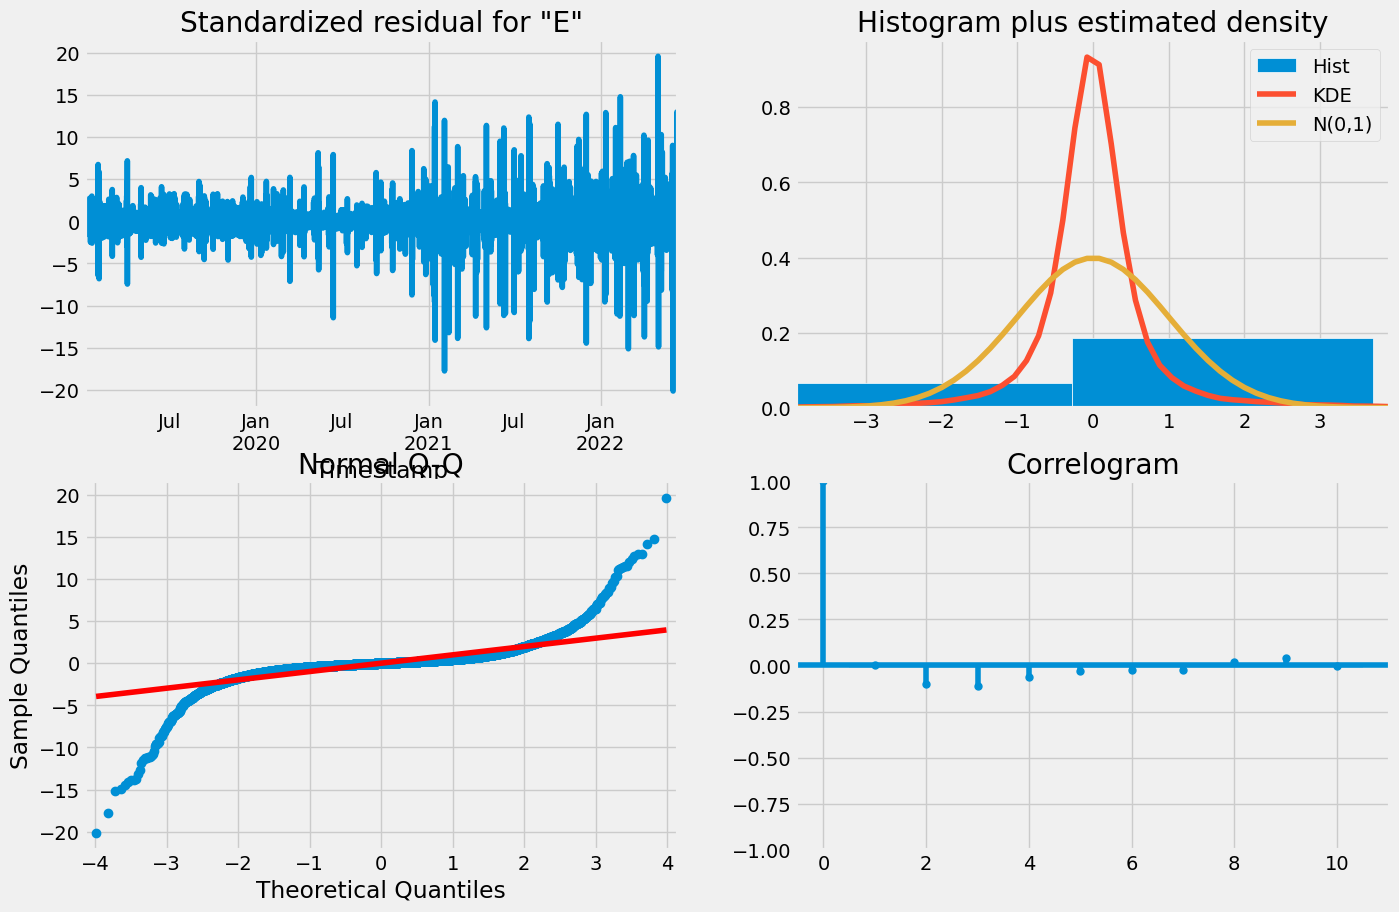

In [13]:
# KDE = kernel density estimate
# Q-Q plot = quantile/quantile
results.plot_diagnostics(figsize=(15, 10))
plt.show()

In [34]:
pred = results.get_forecast(steps=len(test_df),exog=test_df.loc[:, test_df.columns != 'ElectricityPrice'])


In [36]:
pred_ci = pred.conf_int()

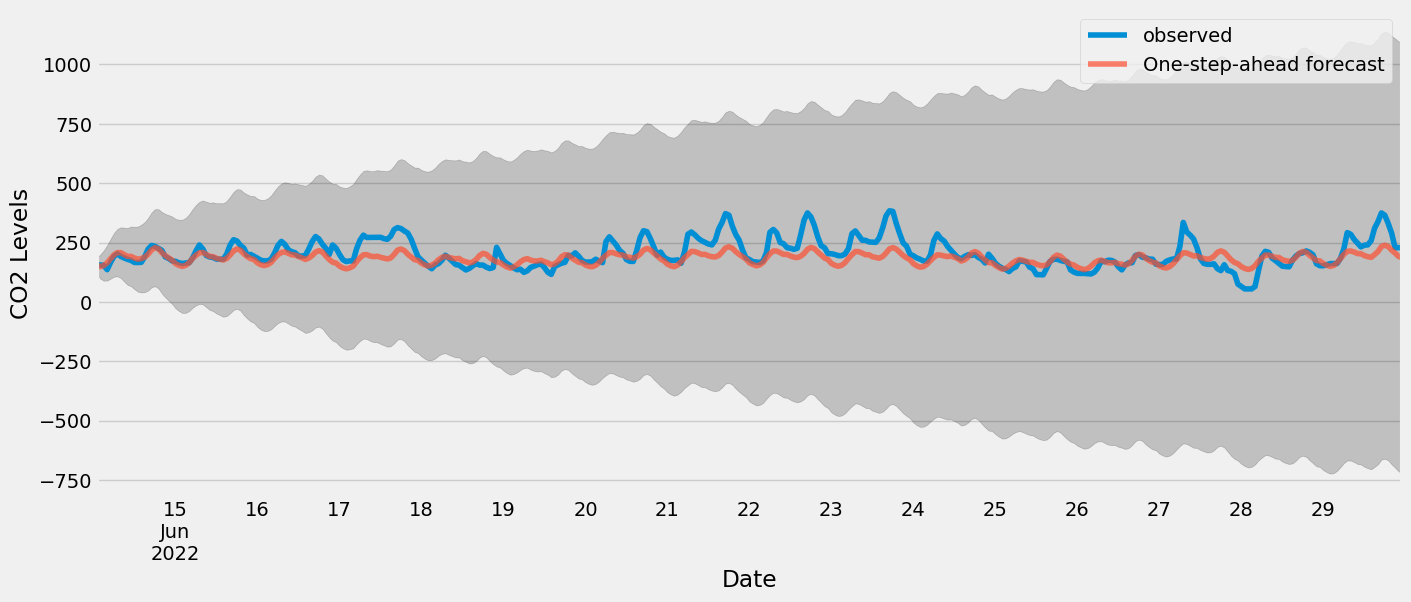

In [41]:
ax = test_df['ElectricityPrice'].plot(label='observed', figsize=(15, 6))
pred.predicted_mean.plot(ax=ax, label='Price forecast', alpha=0.7)

ax.fill_between(
    pred_ci.index,
    pred_ci.iloc[:, 0],
    pred_ci.iloc[:, 1],
    color='k',
    alpha=0.2)

ax.set_xlabel('Date')
ax.set_ylabel('Electricity Price')
plt.legend()
plt.show()

In [42]:
y_forecasted = pred.predicted_mean
y_truth = test_df['ElectricityPrice']

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 2418.76
